# Preprocessing and Build RNN 

1. Import dataset (essays.csv)
2. Load embeddings (Mount to Drive)
3. Function to clean data (strip, lower, non-ASCII)
4. Lemmatize 
5. Vectorize (vector of each word, sum arrays for each word: one number/word)
6. Set vectors to fixed-length (pad short, cut long)
7. Convert categorical lables (y/n to 0/1)
8. Send to csv, download from colab
9. Visualize input data




*   THERE IS SOMETHING WRONG WITH RETURNING THE CSV, GIVES OUTPUT AS STRING
*   FIX INPUT DIMENSIONS TO THE MODEL
*   WHY IS THERE NO LOSS FOR THE MODEL




>[Preprocessing and Model For Personality Dataset](#scrollTo=Yoje3OcUegNP)

>>[Setup Installs](#scrollTo=BqCCKE4IgY47)

>>[TensorBoard Setup](#scrollTo=rFtoDdU1Rh00)

>>[Data Preprocessing](#scrollTo=fG-OpEPHwzD0)

>>>[Define Functions](#scrollTo=fG-OpEPHwzD0)

>>[CNN Model Construction](#scrollTo=ENUwCG2yARtc)

>>>[Prepare Train/Test](#scrollTo=LRsxLQeJ_BXd)

>>>[Build & Fit Model](#scrollTo=xUReXLzK-9Ae)

>>>[Evaluate the model](#scrollTo=Bmcv5ikG9sen)

>>>[Create a graph of accuracy and loss over time](#scrollTo=3STN0-y_-qKQ)

>>[Save Model and Use in Pipeline](#scrollTo=Z5RC91eQDnlQ)

>>>[Save Model Structure](#scrollTo=rYkT_WjSlVSP)

>>>[Use model in pipeline: unseen data](#scrollTo=m4bWTuISllHl)

>>[Save output as csv](#scrollTo=Dx7C8VFzk6P0)

>>[Visualizatoins of Dataset](#scrollTo=i1rSb5Gwwkvm)



## Setup Installs

In [0]:
#standard imports
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import pandas as pd
import re 
import string
import tensorflow as tf
from tensorflow import keras
import json
import datetime, os


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
stop_words = set(stopwords.words('english'))


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split

print(tf.__version__)
# from __future__ import absolute_import, division, print_function, 
# unicode_literals

tf.debugging.set_log_device_placement(True)

TensorFlow 2.x selected.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
2.0.0-rc1


Using TensorFlow backend.


In [0]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

# !pip install tf_nightly
#pip install --upgrade gensim
print("GPU Available: ", tf.test.is_gpu_available())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
GPU Available:  True


In [0]:
init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)


AttributeError: ignored

In [0]:
# import embeddings
from gensim.models import KeyedVectors
filename = '/content/drive/My Drive/trained_models/GoogleNews-vectors-negative300.bin.gz'
emb_model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## TensorBoard Setup
Use popular TensorBoard to show what is happening with the data. Use link to from after import to see how model is training. 

In [0]:
!pip install tensorboardcolab

In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://f077ad40.ngrok.io


In [0]:
# Load the TensorBoard notebook extension
# %tensorboard --logdir logs
%load_ext tensorboard

In [0]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir ./Graph (started 0:00:04 ago; pid 2309)


## Data Preprocessing

### Define Functions
1. text_preprocess: tokenzie, to lower, remove punct,non-ASCII, and numbers (save as 'CLEAN_TEXT')
2. lemmatize: using list returned from previous, lemmatize (update 'CLEAN_TEXT')
3. get_vectors: use clean_text list, apply get vectors to get array for each word, then sum array each word (save as 'TEXT_VECTORS')
4. count_list: count length of lists for each value 
5. fixed_vector: pad short vect, cut long (save as 'SPARSE_VECTORS' for sum and 'DENSE_VECTORS' for full)


Finally, encode the categorical data to 0/1 using a mapping. 

In [0]:
# reading our data
data = pd.read_csv('essays.csv', encoding='latin1')

In [0]:
#define all functions 

def text_preprocess(text_str):
  """ Takes string as input, tokenizes, remove punct, 
      to lower, strip, and remove stop words"""
  
  text = text_str.strip().lower()
  text = re.sub('<[^<]+?>','', text)
  text = re.sub(r'[^\x00-\x7f]',r'', text)
  text = ''.join(c for c in text if not c.isdigit())
  text = text.translate(str.maketrans("","", string.punctuation))
  tokens = word_tokenize(text)
  result = [i for i in tokens if i not in stop_words]
  return result


def lemmatize(list):
  """Take the list returned from previous function
  lemmatize"""
  
  lemmatizer = WordNetLemmatizer()
  lemma = [lemmatizer.lemmatize(x) for x in list]
  return lemma


def dense_vectors(list):
  """For word in list, get embedding,
  add embeddings for word, return all words in list"""

  vectors = []
  for word in list: 
    try:
      vector = emb_model[word]
      vectors.append(vector)
      
    except KeyError: 
      pass
     
  return vectors

def sparse_vectors(list): 
  """For word in list, get embedding,
  add embeddings for word, return all words in list"""

  vectors = []
  for word in list: 
    try:
      vector = emb_model[word]
      vector = np.sum(vector)
      vectors.append(vector)
      
    except KeyError: 
      pass
     
  return vectors


def count_list(list):
  """count items in list, return count"""
  return len(list)


#Pcreate fixed len vectors, only works for the sparse vec
def fixed_vector(vec_list):
  """create fixed length vectors for model input"""
  
  if len(vec_list)>600:
    vec_list = vec_list[:600]
    
  elif len(vec_list)<600: 
    difference = 600-int(len(vec_list))
    vec_list.extend([0.0] * difference)
    
  return vec_list
    

In [0]:
#apply functions 
#the fixed vectors is only for the sparse vec inputs 
data['CLEAN_TEXT'] = data['TEXT'].apply(text_preprocess) #clean text
data['CLEAN_TEXT'] = data['CLEAN_TEXT'].apply(lemmatize) #lemmatize
data['DENSE_VECTORS'] = data['CLEAN_TEXT'].apply(dense_vectors) #create dense vectors
data['SPARSE_VECTORS'] = data['CLEAN_TEXT'].apply(sparse_vectors) #create dense vectors
data['VECTOR_COUNT'] = data['SPARSE_VECTORS'].apply(count_list) #count len vectors for sparse vectors
data['FIXED_VECTORS'] = data['SPARSE_VECTORS'].apply(fixed_vector)#SPARSE vecs to fix length
data['FIXED_VEC_COUNT'] = data['FIXED_VECTORS'].apply(count_list) #len of fix-vec list


In [0]:
#encode categorical data to 0,1
cleanup_nums = {'y': 1.0, 'n': 0.0}
data.replace(cleanup_nums, inplace=True)

In [0]:
data.sample(2)

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,CLEAN_TEXT,DENSE_VECTORS,SPARSE_VECTORS,VECTOR_COUNT,FIXED_VECTORS,FIXED_VEC_COUNT
2458,2004_484.txt,I have so much work to do and it all seems to ...,1.0,1.0,1.0,0.0,0.0,"[much, work, seems, pile, highschool, think, u...","[[0.16894531, 0.063964844, -0.084472656, 0.173...","[-1.7915211, -0.643322, 3.4935741, -0.17520142...",350,"[-1.7915211, -0.643322, 3.4935741, -0.17520142...",600
1779,2002_769785.txt,Why am I doing this? I don't feel like typing ...,1.0,1.0,0.0,1.0,0.0,"[dont, feel, like, typing, minute, bound, bori...","[[0.10498047, -0.032958984, 0.12402344, 0.2294...","[-5.104743, -3.4908142, 0.69479465, -6.8772507...",362,"[-5.104743, -3.4908142, 0.69479465, -6.8772507...",600


### Prepare Train/Test
Prepare input and labels. Fix the dimensions, pad missing values, and check the stuctures.

In [0]:
#features and labels
features = np.matrix([0]*600)
for val in data['FIXED_VECTORS'].values:
  features = np.append(features, [val], axis=0)

  #remove the first all 0 value vec
features = features[1:]
  
labels_ext = data['cEXT'].values

In [0]:
#train test/split using sklearn 
seed = 22
test_size = 0.25
x_train, x_test, y_train, y_test = train_test_split(features, labels_ext, test_size=test_size, random_state=seed)

In [0]:
#reshape 
#No idea why they want this but acording to this link they do https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d/43399308#43399308
x_test = np.expand_dims(x_test, axis=2)
x_train = np.expand_dims(x_train, axis=2)


In [0]:
#check shapes
print('y_test shape:', y_test.shape)
print('x_test shape:', x_test.shape)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

y_test shape: (617,)
x_test shape: (617, 600, 1)
x_train shape: (1850, 600, 1)
y_train shape: (1850,)


## Build RNN 

In [0]:
#define vars
max_len = 600
batch_size = 32
embedding_dims = 1
filters = 250
kernel_size = 3
hidden_dims = 250 
epochs = 20
num_classes =2

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters, 
                 kernel_size, 
                 padding = 'valid', 
                 activation = 'relu',
                 strides = 1,
                 input_shape = (max_len, embedding_dims)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/repl

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [0]:
history = model.fit(x_train, y_train,
         batch_size=batch_size, 
         epochs=10,
         validation_data = (x_test, y_test))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Te

In [0]:
results = model.evaluate(x_test, y_test)
print(results)

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
617/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

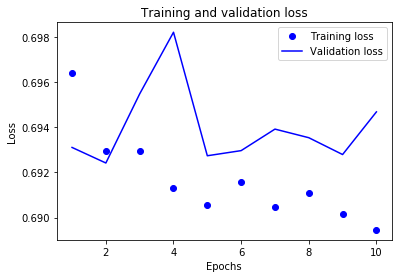

In [0]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

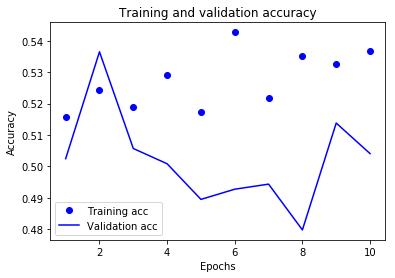

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000) 

## Save Model and Use in Pipeline
We need to be able to use the model on some new text input and make a prediction on the class. Work with JSON to accommplish this. Also we save the model structure.

### Save Model Structure
Save file as JSON format 

In [0]:
#save the model state after training, grab strcuture in JSON 
model_structure = model.to_json()
with open('cnn_model.json', 'w') as json_file:
  json_file.write(model_structure)
model.save_weights('cnn_weights.h5') 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


### Use model in pipeline: unseen data 
Send in some unseen data and see model prediction 

In [0]:
#load saved model 
from keras.models import model_from_json
with open("cnn_model.json", "r") as json_file:
  json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights('cnn_weights.h5')

ValueError: ignored

In [0]:
#test example
sample_1 = "party everyday I like to party i am outgoing dance outside party fun hang out talk people outside world fun happy sun glad talk chat meet funny happpy hangout"
#run functions to get data in shape 
clean_sample = text_preprocess(sample_1)
lemm = lemmatize(clean_sample)
vec_list = sparse_vectors(clean_sample)
test_vec_list = fixed_vector(vec_list)


#convert vectors to the right shape 
test_vec_array = np.asarray(test_vec_list)
test_vec_matrix = np.asmatrix(test_vec_array)
test_vec_matrix = np.expand_dims(test_vec_matrix, axis=2)


print('test_vec matrix shape:', test_vec_matrix.shape)
model.predict(test_vec_matrix)



test_vec matrix shape: (1, 600, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_18050 in device /job:localhost/replica:0/task:0/device:GPU:0


array([[0.5188065]], dtype=float32)